<a href="https://colab.research.google.com/github/dvogureckiy99/Fuzzy/blob/linear_force/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lifting and transport mechanism with two degrees of freedom of the transported cargo 

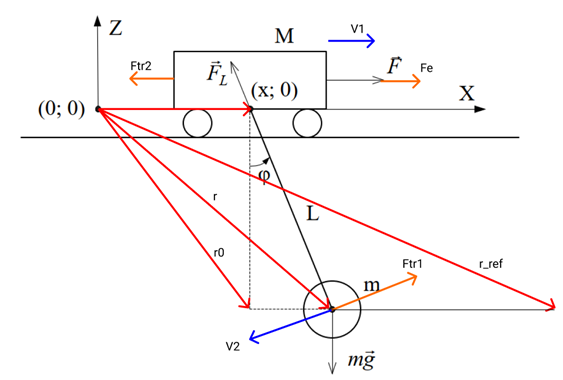

The simplest crane model is a pendulum on a carriage.

Model Parameters:
- $L$ — cable length; 
- $M$ — weight of the trolley; 
- $m$ — Cargo weight; 
- $\varphi$ — load deflection angle; 
- $x$ — distance from the center of the axis to the point of suspension of the load; 
- $F_e$ — the force generated by the electric drive acting on the trolley;
- $F_L$ — the force acting on the cable with the load from the side of the electric lifting drive;
- $r_0,r,r_{ref}$ — radius-vectors of the position of the center of the load initial, current, set respectively;
- $F_{tr1}$ — the force of viscous friction on the cargo air;
- $F_{tr2}$ — the force of viscous friction on the cargo air;
- $F$ $-$ the resulting force acting on the trolley.


\begin{cases} \ddot{x}=
(F_e*L + L^2*d\phi^2*m*sin(\phi) - L*M*g*ktrk*saturation(dx) - L*\dot{x}*k2 - L*g*ktrk*m + 0.5*L*g*m*sin(2*\phi) + d\phi*k_1*cos(\phi))/(L*(M + m*sin(\phi)^2))
 \\  \ddot{\phi}=
-\ddot{x}*cos(\phi)/L - g*sin(\phi)/L - d\phi*k_1/(L^2*m)
  \end{cases}

In [ ]:
!pip install -U scikit-fuzzy

     |████████████████████████████████| 1.0MB 31.3MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp37-none-any.whl size=894088 sha256=e45d719c283b10ce735eface51a0ddbdc743b0bf5a5e0232d39eec8dea54277b
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy


In [ ]:
  !pip install -U control

     |████████████████████████████████| 348kB 27.9MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344929 sha256=fc3838f302ed6f868a456f5c39eaefe4aebbbb9306b36ec0c265582f429323e1
  Stored in directory: /root/.cache/pip/wheels/35/be/ee/081b68ca3e4b2d253fba2f7f7e51960373903fb7b6d13c5532
Successfully built control


In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import control as ct
from control.matlab import * #I want to have a MATLAB-like environment
import matplotlib.pyplot as plt
import scipy as sp

In [ ]:
#creating object dynamics
def port_crane_updfcn(t,s,u,params):
  """A port crane with a cargo on a rope dynamics (like object) 
  assumptions: by all perturbations such as the rolling friction
   force at the point of contact with the rails, air resistance,
    we also assume that the cable is inextensible, i.e. L=const

  Parameters
  ----------
  s: array 
      System state: [x,dx,phi,dphi], where x is a port crane (object) position
      in [0,200] [m], dx is velocity of the port crane in m/s, phi is an angle
      of deflection of the rope with a container, which is a cargo and attached
      to the end of the rope in rad, dphi is angular velocity of the rope 
      deflection in rad/sec

  u: array
      System inputs: [Fe], where Fe is a pulling force exerted on the
      trolley (cart), created by electric motor in Newton

  Returns 
  -------
  float
      [ddx,ddphi], where ddx is a port crane acceleration in m/s^2 and ddphi is 
      angular acceleration in rad/s^2
  """
  from math import sin,cos,sqrt,atan

  # Set up the system parameters
  m = params.get('m', 400.)  # cargo mass in kg
  M = params.get('M', 3000.) # port crane mass in kg
  g = params.get('g', 9.8)    # gravitational constant, m/s^2
  L = params.get('L', 30.)     # length of the drope in m
  k1 = params.get('k1', 8e4)    # static coefficient of  friction acting on the rope in 1/kg
  k2 = params.get('k2',1.5e3)     # static coefficient of friction acting on cargo, it's include viscous friction air and dry friction and other that depend on speed in 1/kg
  ktrk = params.get('ktrk',3e-1)  # coefficient for friction of the cart on the surface

  # Define variables for object state
  x = s[0]    # port crane position in m
  dx = s[1]   # velocity of the port crane in m/s
  phi = s[2]  # deflection of the rope angle in rad
  dphi = s[3] # angular velocity of the rope deflection in rad/sec

  #Define variables for object inputs
  Fe = u[0]   # pulling force exerted on the trolley in Newtons

  v_ktrkmax=2 # установка скорости в м/с, когда значение трени качения установится
  saturation=ct.saturation_nonlinearity(v_ktrkmax) # нелинейность для трения качения,
  ktrk = (ktrk/v_ktrkmax)*saturation(dx)

  # calculating the output variables
  ddx = (Fe*L + L**2*dphi**2*m*sin(phi) - L*M*g*ktrk - L*dx*k2 - L*g*ktrk*m + L*g*m*sin(2*phi)/2 + dphi*k1*cos(phi))/(L*(M + m*sin(phi)**2)) 
  ddphi =  -ddx*cos(phi)/L - g*sin(phi)/L - dphi*k1/(L**2*m)

  return np.array([dx,ddx,dphi,ddphi])

def port_crane_outfcn(t, s, u, params):
  return s[0:4]

In [ ]:
# Define a generator for creating a plots
def system_dynamic_plot(sys, t, y, u, t_start_input=0, x_ref=0, linetype='b-',
                         subplots=[None, None, None],fig_size=None):
  #Figure out the plot bounds and indices
  x_min = 0; x_max = x_ref+math.ceil(x_ref*0.05); x_ind = sys.find_state('x')
  phi_min = -math.pi/18; phi_max = math.pi/18; phi_ind = sys.find_state('phi')
  Fe_min = 0; Fe_max = max(u); Fe_ind = sys.find_input('Fe') 

  #convert phi from rad to deg
  from math import pi 
  y[phi_ind]=y[phi_ind]*180/pi

  # Make sure the upper and lower bounds on x are OK
  while max(y[x_ind]) > x_max: x_max += 1
  while min(y[x_ind]) < x_min: x_min -= 1
  x_max = x_max + x_max * 0.05

  # Make sure the upper and lower bounds on phi are OK
  while max(y[phi_ind]) > phi_max: phi_max += 1
  while min(y[phi_ind]) < phi_min: phi_min -= 1
  phi_max+=1
  phi_min-=1

  # Make sure the upper and lower bounds on Fe are OK
  if len(u.shape)>1:
    while max(u[Fe_ind]) > Fe_max: Fe_max += 1
    while min(u[Fe_ind]) < Fe_min: Fe_min -= 1
  else:
    while max(u) > Fe_max: Fe_max += 1
    while min(u) < Fe_min: Fe_min -= 1
  Fe_max += Fe_max*0.1

  # Create arrays for return values
  subplot_axes = subplots.copy()

  # Position profile
  if subplot_axes[0] is None:
    subplot_axes[0] = plt.subplot(3,1,1)
  else:
    plt.sca(subplots[0])
  plt.plot(t, y[x_ind], linetype)
  plt.plot(t, x_ref*np.ones(t.shape), 'k-')
  plt.plot([t_start_input, t_start_input], [x_min, x_max], 'k--')
  plt.axis([0, t[-1], x_min, x_max])
  plt.xlabel('Time $t$ [s]')
  plt.ylabel('Port crane \nposition $x$')
  plt.grid(color='0.5')
  
  # Angle phi profile
  if subplot_axes[1] is None:
    subplot_axes[1] = plt.subplot(3,1,2)
  else:
    plt.sca(subplots[1])
  plt.plot(t, y[phi_ind], linetype)
  plt.plot([t_start_input, t_start_input], [phi_min, phi_max], 'k--')
  plt.axis([0, t[-1], phi_min, phi_max])
  plt.xlabel('Time $t$ [s]')
  plt.ylabel('deflection of the\n rope angle\n $\phi$ in $\circ$')
  plt.grid(color='0.5')

  # Pulling force
  if subplot_axes[2] is None:
    subplot_axes[2] = plt.subplot(3,1,3)
  else:
    plt.sca(subplots[2])
  if len(u.shape)>1:
    plt.plot(t, u[Fe_ind], linetype)
  else:
    plt.plot(t, u, linetype)
  plt.plot([t_start_input, t_start_input], [Fe_min, Fe_max], 'k--')
  plt.axis([0, t[-1], Fe_min, Fe_max])
  plt.xlabel('Time $t$ [s]')
  plt.ylabel('pulling force Fe,\n $Newton$')
  plt.grid(color='0.5')
  
  return subplot_axes

# State space fuzzy-controller

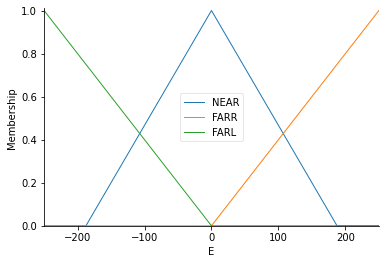

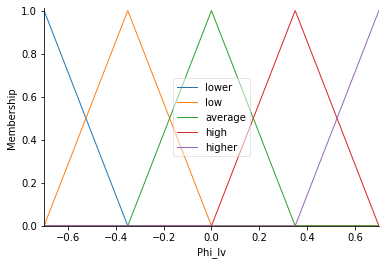

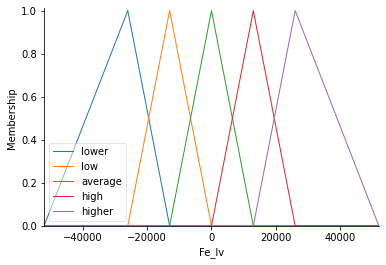

In [ ]:
#Параметры моделирования системы
x_zad=250 # in m

#Сгенерировали нечёткую систему

#Fuzzy regulator parameters init
Fe_abs=5.2e4
Fe_min=-Fe_abs
Fe_max=Fe_abs

# New Antecedent/Consequent objects hold universe variables and
# continues membership functions
N=1e3 # count of point for the universe
E_delta=0.75 # coefficient of reflaction x coordinate from x_zad in x_zad percentage 
E = ctrl.Antecedent(np.linspace(-x_zad, x_zad, int(N+1)), 'E') # input in m with 
Phi_lv = ctrl.Antecedent(np.linspace(-40*math.pi/180, 40*math.pi/180, int(N+1)), 'Phi_lv') # in rad
Fe_lv = ctrl.Consequent(np.linspace(Fe_min, Fe_max, int(N+1)), 'Fe_lv')

# Custom membership functions can be built interactively with a familiar,
# Pythonic API
cuant = ['lower','low','average','high','higher']
cuantE = ['NEAR','FARR','FARL']
E[cuantE[0]] = fuzz.trimf(E.universe, [-E_delta*x_zad, 0, E_delta*x_zad])
E[cuantE[1]] = fuzz.trimf(E.universe, [0,x_zad,x_zad])
E[cuantE[2]] = fuzz.trimf(E.universe, [-x_zad,-x_zad,0])
Fe_lv[cuant[0]] = fuzz.trimf(Fe_lv.universe, [Fe_min*1,Fe_min*0.5,Fe_min*0.25])
Fe_lv[cuant[1]] = fuzz.trimf(Fe_lv.universe, [Fe_min*0.5,Fe_min*0.25,0])
Fe_lv[cuant[2]] = fuzz.trimf(Fe_lv.universe, [Fe_min*0.25,0,Fe_max*0.25])
Fe_lv[cuant[3]] = fuzz.trimf(Fe_lv.universe, [0,Fe_max*0.25,Fe_max*0.5])
Fe_lv[cuant[4]] = fuzz.trimf(Fe_lv.universe, [Fe_max*0.25,Fe_max*0.5,Fe_max*1])
# Auto-membership function population 
Phi_lv.automf(5,'cuant')

E.view()
Phi_lv.view()
Fe_lv.view()

#создание базы правил нечеткой системы
#Fuzzy rules
rule1 = ctrl.Rule(Phi_lv[cuant[0]] & E[cuantE[0]] , Fe_lv[cuant[0]])
rule2 = ctrl.Rule(Phi_lv[cuant[1]] & E[cuantE[0]], Fe_lv[cuant[1]])
rule3 = ctrl.Rule(Phi_lv[cuant[2]] & E[cuantE[0]], Fe_lv[cuant[2]])
rule4 = ctrl.Rule(Phi_lv[cuant[3]] & E[cuantE[0]], Fe_lv[cuant[3]])
rule5 = ctrl.Rule(Phi_lv[cuant[4]] & E[cuantE[0]], Fe_lv[cuant[4]])
rule6 = ctrl.Rule(E[cuantE[1]], Fe_lv[cuant[4]])
rule7 = ctrl.Rule(E[cuantE[2]], Fe_lv[cuant[0]])

#Control System Creation 
sys_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4 , rule5, rule6, rule7])
sys_sim = ctrl.ControlSystemSimulation(sys_ctrl)


In [ ]:
#Input/ouput model for the object
sys_object = ct.NonlinearIOSystem(port_crane_updfcn, port_crane_outfcn, 
                   inputs = ('Fe'), outputs = None, states=('x','dx','phi','dphi'),
                   name='sys_object',params={})

In [ ]:
#nonlinearsystem

def _rhs(self, t, x, u):
    xdot = self.updfcn(t, x, u, self._current_params) \
        if self.updfcn is not None else []
    return np.array(xdot).reshape((-1,))

def _out(self, t, x, u):
    y = self.outfcn(t, x, u, self._current_params) \
        if self.outfcn is not None else x
    return np.array(y).reshape((-1,))

#input_output_response

def _check_convert_array(in_obj, legal_shapes, err_msg_start, squeeze=False,
                         transpose=False):
  # convert nearly everything to an array.
    out_array = np.asarray(in_obj)
    if (transpose):
        out_array = np.transpose(out_array)

    # Test element data type, elements must be numbers
    legal_kinds = set(("i", "f", "c"))  # integer, float, complex
    if out_array.dtype.kind not in legal_kinds:
        err_msg = "Wrong element data type: '{d}'. Array elements " \
                  "must be numbers.".format(d=str(out_array.dtype))
        raise TypeError(err_msg_start + err_msg)

    # If array is zero dimensional (in_obj is scalar):
    # create array with legal shape filled with the original value.
    if out_array.ndim == 0:
        for s_legal in legal_shapes:
            # search for shape that does not contain the special symbol any.
            if "any" in s_legal:
                continue
            the_val = out_array[()]
            out_array = np.empty(s_legal, 'd')
            out_array.fill(the_val)
            break

    # Test shape
    def shape_matches(s_legal, s_actual):
        """Test if two shape tuples match"""
        # Array must have required number of dimensions
        if len(s_legal) != len(s_actual):
            return False
        # All dimensions must contain required number of elements. Joker: "all"
        for n_legal, n_actual in zip(s_legal, s_actual):
            if n_legal == "any":
                continue
            if n_legal != n_actual:
                return False
        return True

    # Iterate over legal shapes, and see if any matches out_array's shape.
    for s_legal in legal_shapes:
        if shape_matches(s_legal, out_array.shape):
            break
    else:
        legal_shape_str = " or ".join([str(s) for s in legal_shapes])
        err_msg = "Wrong shape (rows, columns): {a}. Expected: {e}." \
                  .format(e=legal_shape_str, a=str(out_array.shape))
        raise ValueError(err_msg_start + err_msg)

    # Convert shape
    if squeeze:
        out_array = np.squeeze(out_array)
        # We don't want zero dimensional arrays
        if out_array.shape == tuple():
            out_array = out_array.reshape((1,))

    return out_array

def _update_params(self, params, warning=False):
  # Update the current parameter values
  self._current_params = self.params.copy()
  self._current_params.update(params)

def _find_size(sysval, vecval):
    """Utility function to find the size of a system parameter
    If both parameters are not None, they must be consistent.
    """
    if hasattr(vecval, '__len__'):
        if sysval is not None and sysval != len(vecval):
            raise ValueError("Inconsistend information to determine size "
                             "of system component")
        return len(vecval)
    # None or 0, which is a valid value for "a (sysval, ) vector of zeros".
    if not vecval:
        return 0 if sysval is None else sysval
    elif sysval == 1:
        # (1, scalar) is also a valid combination from legacy code
        return 1
    raise ValueError("Can't determine size of system component.")

def _process_time_response(
        sys, tout, yout, xout, u,transpose=None, return_x=False,return_t_u_y = False,
        squeeze=None, input=None, output=None):
      # If squeeze was not specified, figure out the default (might remain None)
    if squeeze is None:
        squeeze = config.defaults['control.squeeze_time_response']

    # Determine if the system is SISO
    issiso = sys.issiso() or (input is not None and output is not None)

    # Figure out whether and how to squeeze output data
    if squeeze is True:         # squeeze all dimensions
        yout = np.squeeze(yout)
    elif squeeze is False:      # squeeze no dimensions
        pass
    elif squeeze is None:       # squeeze signals if SISO
        if issiso:
            if len(yout.shape) == 3:
                yout = yout[0][0]       # remove input and output
            else:
                yout = yout[0]          # remove input
    else:
        raise ValueError("unknown squeeze value")

    # Figure out whether and how to squeeze the state data
    if issiso and xout is not None and len(xout.shape) > 2:
        xout = xout[:, 0, :]            # remove input

    # See if we need to transpose the data back into MATLAB form
    if transpose:
        # Transpose time vector in case we are using np.matrix
        tout = np.transpose(tout)

        # For signals, put the last index (time) into the first slot
        yout = np.transpose(yout, np.roll(range(yout.ndim), 1))
        if xout is not None:
            xout = np.transpose(xout, np.roll(range(xout.ndim), 1))

    # Return time, output, and (optionally) state
    if return_x: 
      return (yout, xout) 
    elif return_t_u_y:  
      return (tout, u, yout)
    else:
      return (yout)

def input_output_response(
        sys, T, x_zad=0., X0=0, params={},
        transpose=False, return_t_u_y=False, squeeze=None,Fuzzy_regulator=None,
        solve_ivp_kwargs={}, **kwargs):
  """Compute the output response of a system to a given input.'''
  """

  # Set the default method to 'RK45'
  if solve_ivp_kwargs.get('method', None) is None:
    solve_ivp_kwargs['method'] = 'RK45'

  # Compute the time interval and number of steps
  T0, Tf = T[0], T[-1]
  n_steps = len(T)  
  dt=T[1]-T[0]
  # Update the parameter values
  sys._update_params(params)
  
  global U,Tnew
  U=[]
  Tnew=[]
  def ufun(t,x):
    global U,Tnew
    Tnew=np.append(Tnew,t)
    sys_sim.input['E'] = x_zad-x[0] #ошибка по координате
    sys_sim.input['Phi_lv'] = x[2]  #ошибка по углу отклонения
    sys_sim.compute()
    U=np.append(U,sys_sim.output['Fe_lv'])
    return [U[-1]]
  

  # Create a lambda function for the right hand side
  def ivp_rhs(t, x):
    return sys._rhs(t, x, ufun(t,x))

  if not hasattr(sp.integrate, 'solve_ivp'):
    raise NameError("scipy.integrate.solve_ivp not found; "
                        "use SciPy 1.0 or greater")
  soln = sp.integrate.solve_ivp(
      ivp_rhs, (T0, Tf), X0, t_eval=T,
      vectorized=False, **solve_ivp_kwargs) #шаг расчёта переменный

  U=np.interp(T,Tnew,U)

  if sys.ninputs is None or sys.ninputs == 1:
      legal_shapes = [(n_steps,), (1, n_steps)]
  else:
      legal_shapes = [(sys.ninputs, n_steps)]

  #U = _check_convert_array(U, legal_shapes,
  #                        'Parameter ``U``: ', squeeze=False)

  # Compute the output associated with the state (and use sys.out to
  # figure out the number of outputs just in case it wasn't specified)
  y = np.zeros((np.shape(sys._out(Tnew[0], X0, x_zad))[0], len(T)))
  u = U[0] if len(U.shape) == 1 else U[:, 0]
  for i in range(len(T)):
    u = U[i] if len(U.shape) == 1 else U[:, i]
    y[:, i] = sys._out(T[i], soln.y[:, i], u )
                       
  return _process_time_response(sys, T, y, soln.y,U, transpose=transpose,
                                  return_t_u_y=return_t_u_y, squeeze=squeeze)

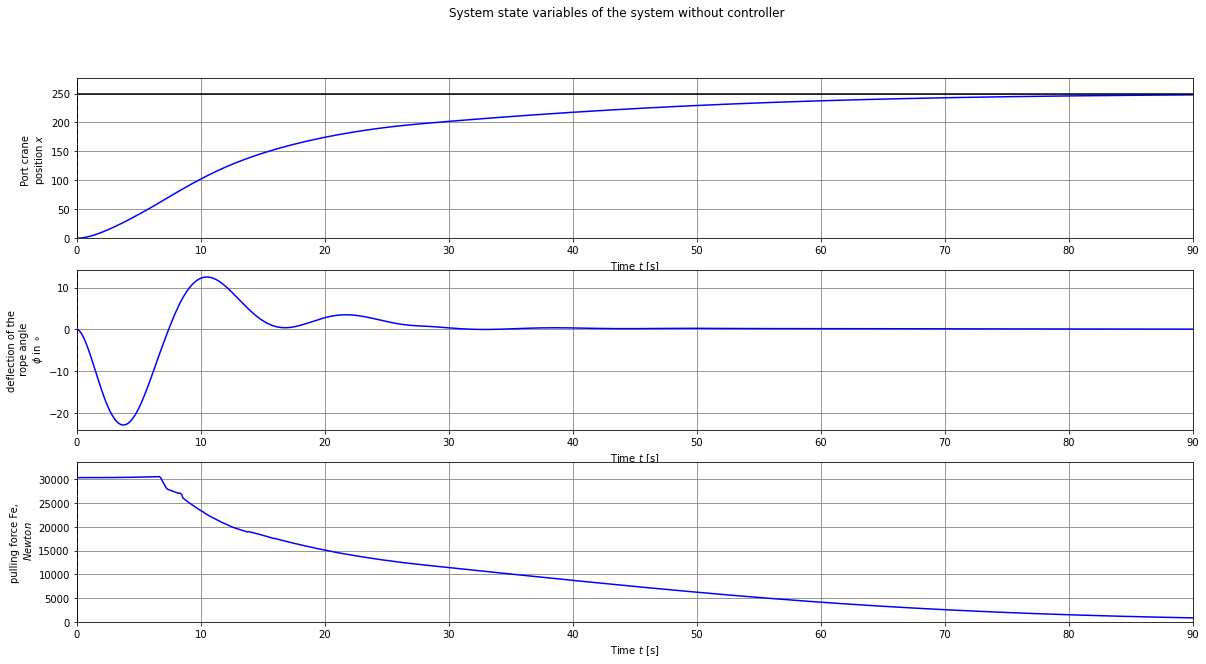

In [ ]:
# Define the generator for simulating an system with Fuzzy-controller

# Define the time and i02nkput vectors
time_start_force=0
T_N=int(1e3+1) #points for simulation
time_interval_stop = 90 # length of time interval in sec 
time_application_of_force = 10

T = np.linspace(0, time_interval_stop, (T_N))
N_time_start_force = math.ceil((time_start_force/time_interval_stop)*(T_N))

N_time_application_of_force = math.ceil((time_application_of_force/time_interval_stop)*(T_N))

sys_initial_state = np.array([[0],[0],[0],[0]]) 
(tout, u, sys_state) = input_output_response(sys_object, T, x_zad,  sys_initial_state[0:4,0],
                                  params={},Fuzzy_regulator=sys_sim,return_t_u_y=True)   
#create graphics
figsize=(20,10)
plt.figure(figsize=figsize)  
subplots = system_dynamic_plot(sys_object, tout, sys_state, u=u ,x_ref=x_zad,
         t_start_input=time_start_force, linetype='-b',fig_size=figsize)

# Add title and legend
plt.suptitle('System state variables of the system without controller')
import matplotlib.lines as mlines
pi_line = mlines.Line2D([], [], color='blue', linestyle='-', label='without controller')